# $\text{UF}_{2,3}$ Demo: Outer Hyperparameter Optimization

This jupyter notebook demonstrates how radial cutoffs (outer) hyperparameters can be optimized using a signle HDF5 feature file generated using a very large 2-body and 3-body cutoff

In [2]:
import os
from concurrent.futures import ProcessPoolExecutor

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
from uf3.data import io
from uf3.data import geometry
from uf3.data import composition
from uf3.representation import bspline
from uf3.representation import process
from uf3.regression import least_squares
from uf3.util.optimize import (get_bspline_config, 
                               get_possible_lower_cutoffs, 
                               get_columns_to_drop_2b, 
                               get_columns_to_drop_3b)

**Inputs**
- ```w-14.xyz``` Contains the training data. Available at [qmml.org](https://qmml.org/datasets.html)
- ```training_idx.txt``` Contains the training keys. Included for reproducibility purposes

In [4]:
#System Defination
element_list = ['W']
degree = 3

chemical_system = composition.ChemicalSystem(element_list=element_list, degree=degree)

When creating HDF5 file for outer hyperparameter optimization, we **recommend** using the ```get_bspline_config``` function for constructing the ```bspline``` object. The final cutoffs in the ```bspline``` object might be slightly different from the user provided cutoffs depending on the ```knot_spacing```.

In [6]:
rmin = 0 #Min of radial cutoff. Current version has been tested only for rmin=0

knot_spacing = 0.5 #spacing between consecutive knots

rmax_2b = 8 #Cutoff 2-body

rmax_3b = 8 #Cutoff 3-body. If A-B-C are the interacting bodies with A as the central atom. Then rmax_3b is 
             #maximum possible distance between B and C. Max dist(A,B) = Max dist(A,C) = rmax_3b/2.

bspline_config = get_bspline_config(chemical_system=chemical_system,
                                    rmin=rmin,
                                    rmax_2b=rmax_2b,
                                    rmax_3b=rmax_3b,
                                    knot_spacing=knot_spacing)

In [7]:
bspline_config.knots_map

{('W',
  'W'): array([0. , 0. , 0. , 0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5,
        5. , 5.5, 6. , 6.5, 7. , 7.5, 8. , 8. , 8. , 8. ]),
 ('W',
  'W',
  'W'): [array([0. , 0. , 0. , 0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4. ,
         4. , 4. ]), array([0. , 0. , 0. , 0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4. ,
         4. , 4. ]), array([0. , 0. , 0. , 0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5,
         5. , 5.5, 6. , 6.5, 7. , 7.5, 8. , 8. , 8. , 8. ])]}

The current version is only tested for ```leading_trim=0``` and ```trailing_trim=3```. These options are hard coded in ```get_bspline_config``` function.

In [8]:
bspline_config.leading_trim, bspline_config.trailing_trim

(0, 3)

# Load training keys

In [9]:
example_directory = os.getcwd()
data_filename = os.path.join(example_directory, "w-14.xyz")
with open(os.path.join(example_directory, "training_idx.txt"), "r") as f:
    training_1939 = [int(idx) for idx in f.read().splitlines()]

# Load data

In [10]:
data_coordinator = io.DataCoordinator()
data_coordinator.dataframe_from_trajectory(data_filename,
                                           prefix='dft')
df_data = data_coordinator.consolidate()
print("Number of energies:", len(df_data))
print("Number of forces:", int(np.sum(df_data["size"]) * 3))

Number of energies: 9693
Number of forces: 475578


# Compute energy and force features
This is the most expensive step. For demonstration purpose we will only featurize 200 randomly selected entries

In [11]:
df_random = df_data.sample(n=200)
df_random

,geometry,energy,fx,fy,fz,size
dft_3723,"(Atom('W', [0.1315152101611703, -0.04072203314...",-131.683672,"[-0.5631635175458239, 0.3046964519160928, 0.08...","[1.292515314434171, -0.3968417536067168, -0.04...","[-0.4625501438001352, 0.5033050481969475, -0.2...",12.0
dft_3950,"(Atom('W', [0.08777660678182433, 0.30634855366...",-130.469693,"[-0.1698690092595914, -1.188005899912112, -2.2...","[-0.675309185612447, -1.211548934940512, 2.929...","[-0.08297464697951867, 0.4934663587643311, 0.9...",12.0
dft_2853,"(Atom('W', [-0.04241142327680498, -0.084976386...",-127.207663,"[1.395282702672477, -3.418483409962219, -1.636...","[0.7222678839971549, 2.51213358808685, -2.4028...","[2.449277553007078, -2.530518411492719, -3.514...",12.0
dft_8420,"(Atom('W', [-0.008737680675093484, 0.019118631...",-126.934943,"[1.553164079724961, -0.9515368059440824, -2.42...","[-0.2567458650353278, -2.792348092601493, -0.2...","[-2.795573244558019, -3.49901163335988, -5.983...",12.0
dft_8204,"(Atom('W', [0.453023655001659, -0.054960904246...",-129.289374,"[1.409414563975787, 0.8415521024110698, 0.5481...","[-1.362703919832366, -1.016822309836143, -0.30...","[1.359337762454701, -0.8635756963315664, 1.114...",12.0
...,...,...,...,...,...,...
dft_9559,"(Atom('W', [0.1049797981109828, 0.050895593932...",-514.389999,"[-0.4357475553275329, -0.1897758012704394, -0....","[0.3555817491667317, -0.9063377546837946, 0.27...","[0.5666390088553412, 0.9296697759179474, 0.213...",47.0
dft_7959,"(Atom('W', [-0.02026014156534555, -0.264820090...",-132.753240,"[0.3220565285028751, 0.01393160348510604, 0.59...","[-0.1921699762738479, -0.0144708295106171, 1.0...","[1.247624906882817, -0.3771731084220308, -2.55...",12.0
dft_6959,"(Atom('W', [0.1571610621426283, 0.289109272337...",-126.020134,"[-1.084706605483888, 0.4190006498578611, -2.76...","[-4.798603879406634, -0.6731704059871089, 0.00...","[-1.217799236374942, 2.119661332485893, 2.9578...",12.0
dft_6179,"(Atom('W', [-0.02150361166141894, -0.480577767...",-129.459971,"[0.8400575313565661, -1.666354286048934, -1.88...","[-1.391696628600643, -0.0298172916607678, 1.15...","[-1.513914888094333, 1.739751267835089, -3.806...",12.0


In [50]:
filename = "df_features_2b8_3b8_ks"+str(knot_spacing)+".h5"
table_template = "features_{}"

In [13]:
n_cores = 16
representation = process.BasisFeaturizer(bspline_config)
client = ProcessPoolExecutor(max_workers=n_cores)

In [14]:
representation.batched_to_hdf(filename,
                              df_random,
                              client,
                              n_jobs = n_cores,
                              batch_size=10,
                              progress="bar",
                              table_template=table_template)

  0%|          | 0/20 [00:00<?, ?it/s]

Process ForkProcess-10:
Process ForkProcess-5:
Process ForkProcess-7:
Process ForkProcess-3:
Process ForkProcess-12:
Process ForkProcess-16:
Process ForkProcess-1:
Process ForkProcess-6:
Process ForkProcess-14:
Process ForkProcess-11:
Process ForkProcess-8:
Process ForkProcess-13:
Process ForkProcess-9:
Process ForkProcess-15:
Process ForkProcess-2:
Process ForkProcess-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ajinkya.hire/ls/envs/uf3_env/lib/python3.8/multipro

  File "/home/ajinkya.hire/ls/envs/uf3_env/lib/python3.8/multiprocessing/queues.py", line 96, in get
    with self._rlock:
  File "/home/ajinkya.hire/ls/envs/uf3_env/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ajinkya.hire/ls/envs/uf3_env/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ajinkya.hire/ls/envs/uf3_env/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ajinkya.hire/ls/envs/uf3_env/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ajinkya.hire/ls/envs/uf3_env/lib/python3.8/multiprocessing/queues.py", line 96, in get
    with self._rlock:
  File "/home/ajinkya.hire/ls/envs/uf3_env/lib/python3.8/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=Tru

Once the HDF5 feature file is genererated, use ```get_possible_lower_cutoffs``` function to get all the possible cutoff values for ```rmax_2b``` and ```rmax_3b```.

In [23]:
rmax_2b_poss, rmax_3b_poss = get_possible_lower_cutoffs(original_bspline_config=bspline_config)

In [24]:
rmax_2b_poss

array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ])

**Remember** that if A-B-C are the interacting bodies with A as the central atom, then rmax_3b_poss is a list of maximum possible distances between B and C. Max dist(A,B) = Max dist(A,C) = rmax_3b/2.

In [25]:
rmax_3b_poss

array([3., 4., 5., 6., 7., 8.])

Let's make a list of outer hyperparameter.

Generally the cutoff of 3-body interaction (maximum side length of the triangle) is less than or euqal to 2-body cutoff.

We will first make a ```meshgrid``` out of ```rmax_2b_poss``` and ```rmax_3b_poss```, and then apply the above condition.

**Note** for the current implementation to work it is not necessary to follow the above condition 

In [26]:
rmax_3b_poss, rmax_2b_poss = np.meshgrid(rmax_3b_poss, rmax_2b_poss)

rmax_3b_poss, rmax_2b_poss = rmax_3b_poss.flatten(), rmax_2b_poss.flatten()

In [29]:
outer_hp = []
                                        
for i in range(rmax_2b_poss.shape[0]):
    if rmax_3b_poss[i]<=rmax_2b_poss[i]:
        outer_hp.append([rmax_2b_poss[i],rmax_3b_poss[i]])
outer_hp

[[3.0, 3.0],
 [3.5, 3.0],
 [4.0, 3.0],
 [4.0, 4.0],
 [4.5, 3.0],
 [4.5, 4.0],
 [5.0, 3.0],
 [5.0, 4.0],
 [5.0, 5.0],
 [5.5, 3.0],
 [5.5, 4.0],
 [5.5, 5.0],
 [6.0, 3.0],
 [6.0, 4.0],
 [6.0, 5.0],
 [6.0, 6.0],
 [6.5, 3.0],
 [6.5, 4.0],
 [6.5, 5.0],
 [6.5, 6.0],
 [7.0, 3.0],
 [7.0, 4.0],
 [7.0, 5.0],
 [7.0, 6.0],
 [7.0, 7.0],
 [7.5, 3.0],
 [7.5, 4.0],
 [7.5, 5.0],
 [7.5, 6.0],
 [7.5, 7.0],
 [8.0, 3.0],
 [8.0, 4.0],
 [8.0, 5.0],
 [8.0, 6.0],
 [8.0, 7.0],
 [8.0, 8.0]]

As an example let's fit a model with ```rmax_2b = 5```, and ```rmax_3b = 4.0``` with no regularization and energy force weight =1

In [44]:
rmax_2b = outer_hp[7][0]
rmax_3b = outer_hp[7][1]

bspline_config_lower_cutoff = get_bspline_config(chemical_system=chemical_system,
                                                 rmin=rmin,
                                                 rmax_2b=rmax_2b,
                                                 rmax_3b=rmax_3b,
                                                 knot_spacing=knot_spacing)
bspline_config_lower_cutoff.knots_map

{('W',
  'W'): array([0. , 0. , 0. , 0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5,
        5. , 5. , 5. , 5. ]),
 ('W',
  'W',
  'W'): [array([0. , 0. , 0. , 0. , 0.5, 1. , 1.5, 2. , 2. , 2. , 2. ]), array([0. , 0. , 0. , 0. , 0.5, 1. , 1.5, 2. , 2. , 2. , 2. ]), array([0. , 0. , 0. , 0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4. ,
         4. , 4. ])]}

We need to know what columns to drop from the generated HDF5 file, so that the features correspond to cutoffs of ```rmax_2b = 5```, and ```rmax_3b = 4.0```

In [52]:
columns_to_drop_2b = get_columns_to_drop_2b(original_bspline_config=bspline_config,
                                         modify_2b_cutoff=rmax_2b,
                                         knot_spacing=knot_spacing)

columns_to_drop_3b = get_columns_to_drop_3b(original_bspline_config=bspline_config,
                                            modify_3b_cutoff=rmax_3b,knot_spacing=knot_spacing)

columns_to_drop = columns_to_drop_2b
columns_to_drop.extend(columns_to_drop_3b)

In [53]:
regularizer = bspline_config_lower_cutoff.get_regularization_matrix(ridge_1b=0,
                                                                    ridge_2b=0.0,
                                                                    ridge_3b=0)

model = least_squares.WeightedLinearModel(bspline_config_lower_cutoff, regularizer=regularizer)

In [54]:
model.fit_from_file(filename="df_features_2b8_3b8_ks0.5.h5", 
                    subset=list(df_random.index),
                    weight=1,
                    batch_size=100,
                    energy_key="energy", 
                    progress="bar",
                    drop_columns=columns_to_drop)

  0%|          | 0/20 [00:00<?, ?it/s]

In [55]:
y_e, p_e, y_f, p_f, rmse_e, rmse_f = model.batched_predict(filename="df_features_2b8_3b8_ks0.5.h5",
                                                           keys=list(df_random.index),
                                                          drop_columns=columns_to_drop)

RMSE (energy): 0.028
RMSE (forces): 0.437


Next we will create 5-folds out of the 200 randomly generated structures

In [56]:
df_folds = [i for i in np.array_split(df_random,5)]

Now we will fit models for all values in ```outer_hp``` and perform 5-fold CV.

For demonstration we are not optimizing **inner hyperparameters** i.e regularizers

In [77]:
results = []

for i in outer_hp:
    rmax_2b = i[0]
    rmax_3b = i[1]
    data = [rmax_2b,rmax_3b]
    print(rmax_2b,rmax_3b)
    bspline_config_lower_cutoff = get_bspline_config(chemical_system=chemical_system,
                                                     rmin=rmin,
                                                     rmax_2b=rmax_2b,
                                                     rmax_3b=rmax_3b,
                                                     knot_spacing=knot_spacing)
    
    columns_to_drop_2b = get_columns_to_drop_2b(original_bspline_config=bspline_config,
                                                modify_2b_cutoff=rmax_2b,
                                                knot_spacing=knot_spacing)

    columns_to_drop_3b = get_columns_to_drop_3b(original_bspline_config=bspline_config,
                                                modify_3b_cutoff=rmax_3b,
                                                knot_spacing=knot_spacing)
    
    columns_to_drop = columns_to_drop_2b
    columns_to_drop.extend(columns_to_drop_3b)
    
    for hold_out_fold in range(0,5):
        df_train_data = [df_folds[j].copy() for j in range(len(df_folds)) if j!=hold_out_fold]
        df_valid_data = df_folds[hold_out_fold]
        
        df_train_data = pd.concat(df_train_data)
        
        training_keys = list(df_train_data.index)
        validation_keys = list(df_valid_data.index)
        
        regularizer = bspline_config_lower_cutoff.get_regularization_matrix(ridge_1b=0,
                                                                    ridge_2b=0.0,
                                                                    ridge_3b=0)

        model = least_squares.WeightedLinearModel(bspline_config_lower_cutoff, regularizer=regularizer)
        
        model.fit_from_file(filename="df_features_2b8_3b8_ks0.5.h5",
                            subset=training_keys,
                            weight=1,
                            batch_size=100,
                            energy_key="energy", 
                            progress=None,
                            drop_columns=columns_to_drop)
        
        yt_e, pt_e, yt_f, pt_f, rmset_e, rmset_f = model.batched_predict(filename="df_features_2b8_3b8_ks0.5.h5",
                                                                         keys=training_keys,
                                                                         drop_columns=columns_to_drop)
        
        yv_e, pv_e, yv_f, pv_f, rmsev_e, rmsev_f = model.batched_predict(filename="df_features_2b8_3b8_ks0.5.h5",
                                                                         keys=validation_keys,
                                                                         drop_columns=columns_to_drop)
        if hold_out_fold ==0:                                                   
            errors = np.array([rmset_e,rmset_f,rmsev_e,rmsev_f])     
        else:                                                                   
            errors = errors + np.array([rmset_e,rmset_f,rmsev_e,rmsev_f])
            
    errors = errors/5
    data.extend(list(errors))
    results.append(data)

3.0 3.0
RMSE (energy): 0.082
RMSE (forces): 0.738
RMSE (energy): 0.185
RMSE (forces): 0.954
RMSE (energy): 0.114
RMSE (forces): 0.668
RMSE (energy): 0.089
RMSE (forces): 0.590
RMSE (energy): 0.114
RMSE (forces): 0.654
RMSE (energy): 0.090
RMSE (forces): 0.552
RMSE (energy): 0.117
RMSE (forces): 0.644
RMSE (energy): 0.077
RMSE (forces): 0.628
RMSE (energy): 0.117
RMSE (forces): 0.612
RMSE (energy): 0.073
RMSE (forces): 0.718
3.5 3.0
RMSE (energy): 0.071
RMSE (forces): 0.791
RMSE (energy): 0.175
RMSE (forces): 0.891
RMSE (energy): 0.105
RMSE (forces): 0.761
RMSE (energy): 0.076
RMSE (forces): 0.724
RMSE (energy): 0.106
RMSE (forces): 0.752
RMSE (energy): 0.073
RMSE (forces): 0.661
RMSE (energy): 0.106
RMSE (forces): 0.746
RMSE (energy): 0.075
RMSE (forces): 0.763
RMSE (energy): 0.107
RMSE (forces): 0.696
RMSE (energy): 0.064
RMSE (forces): 0.803
4.0 3.0
RMSE (energy): 0.030
RMSE (forces): 0.471
RMSE (energy): 0.044
RMSE (forces): 0.511
RMSE (energy): 0.031
RMSE (forces): 0.482
RMSE (ener

RMSE (energy): 0.018
RMSE (forces): 1.642
RMSE (energy): 0.022
RMSE (forces): 1.271
RMSE (energy): 0.018
RMSE (forces): 1.143
RMSE (energy): 0.054
RMSE (forces): 3.480
RMSE (energy): 0.017
RMSE (forces): 1.267
RMSE (energy): 0.035
RMSE (forces): 1.111
RMSE (energy): 0.018
RMSE (forces): 0.850
RMSE (energy): 0.026
RMSE (forces): 0.987
7.0 3.0
RMSE (energy): 0.021
RMSE (forces): 0.444
RMSE (energy): 0.048
RMSE (forces): 0.538
RMSE (energy): 0.021
RMSE (forces): 0.422
RMSE (energy): 0.025
RMSE (forces): 0.397
RMSE (energy): 0.022
RMSE (forces): 0.416
RMSE (energy): 0.025
RMSE (forces): 0.397
RMSE (energy): 0.021
RMSE (forces): 0.416
RMSE (energy): 0.029
RMSE (forces): 0.422
RMSE (energy): 0.023
RMSE (forces): 0.413
RMSE (energy): 0.020
RMSE (forces): 0.428
7.0 4.0
RMSE (energy): 0.021
RMSE (forces): 0.444
RMSE (energy): 0.048
RMSE (forces): 0.538
RMSE (energy): 0.021
RMSE (forces): 0.422
RMSE (energy): 0.025
RMSE (forces): 0.397
RMSE (energy): 0.022
RMSE (forces): 0.416
RMSE (energy): 0.0

In [83]:
df_result = pd.DataFrame(results,columns=["rmax_2b","rmax_3b","training_error_energy","traininig_error_force",
                                         "validation_error_energy","validation_error_force"])
df_result

,rmax_2b,rmax_3b,training_error_energy,traininig_error_force,validation_error_energy,validation_error_force
0,3.0,3.0,0.108826,0.663300,0.102813,0.688377
1,3.5,3.0,0.098933,0.749328,0.092521,0.768384
2,4.0,3.0,0.030823,0.476911,0.034662,0.492951
3,4.0,4.0,0.030823,0.476911,0.034662,0.492951
4,4.5,3.0,0.027530,0.433362,0.028814,0.444248
5,4.5,4.0,0.027530,0.433362,0.028814,0.444248
6,5.0,3.0,0.027408,0.438784,0.028826,0.450266
7,5.0,4.0,0.027408,0.438784,0.028826,0.450266
8,5.0,5.0,0.026260,0.538771,0.034985,0.928101
9,5.5,3.0,0.027350,0.436801,0.029371,0.445980


In [91]:
%matplotlib ipympl
df_result.sort_values(by=["rmax_2b","rmax_3b"],inplace=True)

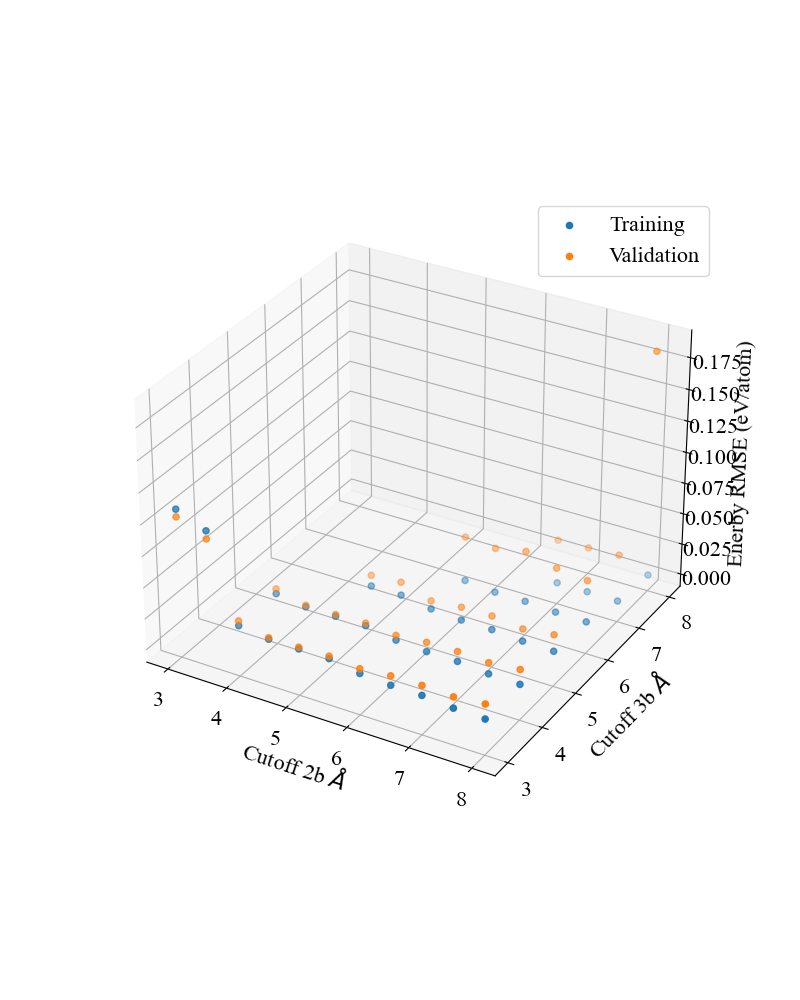

In [94]:
plt.clf()
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.subplots_adjust(left=0.15,bottom=0.07,right=0.99,top=0.99,hspace=0.05)
fig, axs = plt.subplots(figsize=(8,10),subplot_kw={"projection": "3d"})

cutoff_2b = df_result["rmax_2b"].to_numpy()
cutoff_3b = df_result["rmax_3b"].to_numpy()
energy_train_error = df_result["training_error_energy"].to_numpy()
energy_valid_error = df_result["validation_error_energy"].to_numpy()

axs.scatter(cutoff_2b,cutoff_3b,energy_train_error,label="Training")
axs.scatter(cutoff_2b,cutoff_3b,energy_valid_error,label="Validation")

axs.set_xlabel(r"Cutoff 2b $\AA$")
axs.set_ylabel(r"Cutoff 3b $\AA$")
axs.set_zlabel(r"Enerby RMSE (eV/atom)")

axs.legend()

Text(0.5, 0, 'Model Complexity - 2B cutoff radius ($\\AA$)')

<Figure size 640x480 with 0 Axes>

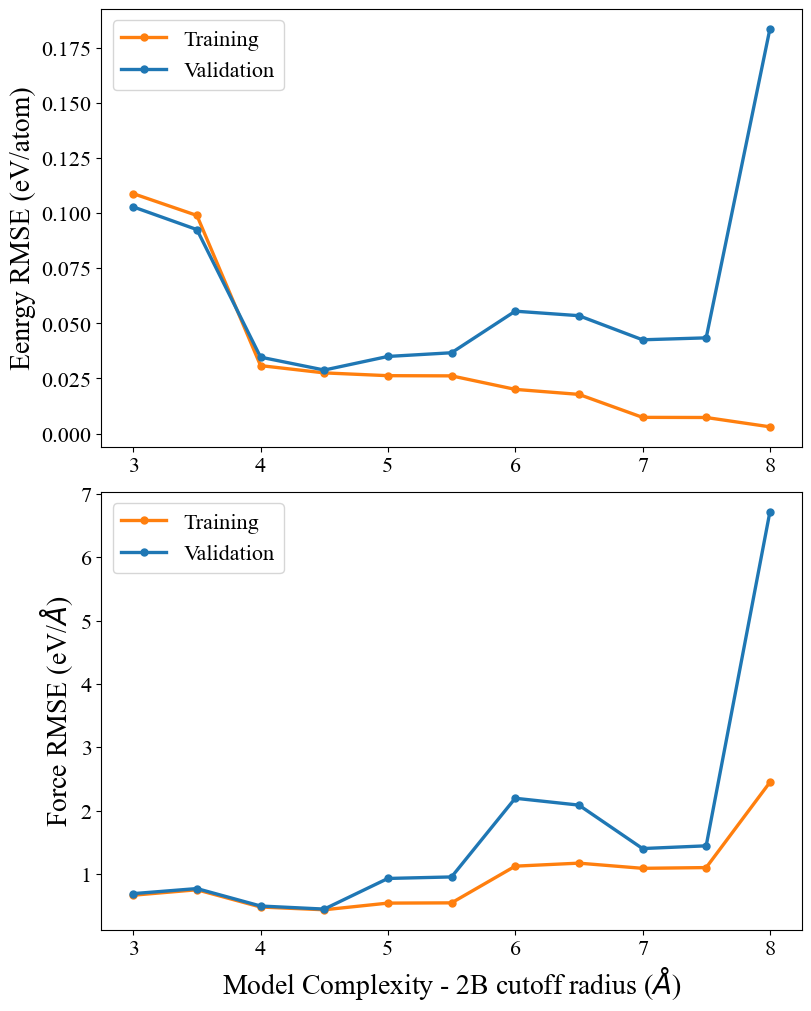

In [88]:
df_result.sort_values(by="rmax_2b",inplace=True)
plt.clf()
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.subplots_adjust(left=0.15,bottom=0.07,right=0.99,top=0.99,hspace=0.05)
fig, axs = plt.subplots(2,1,figsize=(8,10),constrained_layout = True)

energy_train_error = []
energy_valid_error = []

force_train_error = []
force_valid_error = []

cutoff_2b = df_result["rmax_2b"].unique()
for i in cutoff_2b:
    df_temp = df_result.loc[df_result["rmax_2b"]==i].copy()
    df_temp.sort_values(by="training_error_energy",inplace=True)
    energy_train_error.append(df_temp["training_error_energy"].to_numpy()[0])
    energy_valid_error.append(df_temp["validation_error_energy"].to_numpy()[0])
    
    force_train_error.append(df_temp["traininig_error_force"].to_numpy()[0])
    force_valid_error.append(df_temp["validation_error_force"].to_numpy()[0])

axs[0].plot(cutoff_2b,energy_train_error,'.-',color="tab:orange",lw=2.4,ms=10,label="Training")
axs[0].plot(cutoff_2b,energy_valid_error,'.-',color="tab:blue",lw=2.4,ms=10,label="Validation")
axs[0].set_ylabel("Eenrgy RMSE (eV/atom)",fontsize=20)
axs[0].legend()

axs[1].plot(cutoff_2b,force_train_error,'.-',color="tab:orange",lw=2.4,ms=10,label="Training")
axs[1].plot(cutoff_2b,force_valid_error,'.-',color="tab:blue",lw=2.4,ms=10,label="Validation")
axs[1].set_ylabel(r"Force RMSE (eV/$\AA$)",fontsize=20)
axs[1].legend()
axs[1].set_xlabel(r"Model Complexity - 2B cutoff radius ($\AA$)",fontsize=20)

Text(0.5, 0, 'Model Complexity - 3B cutoff radius ($\\AA$)')

<Figure size 640x480 with 0 Axes>

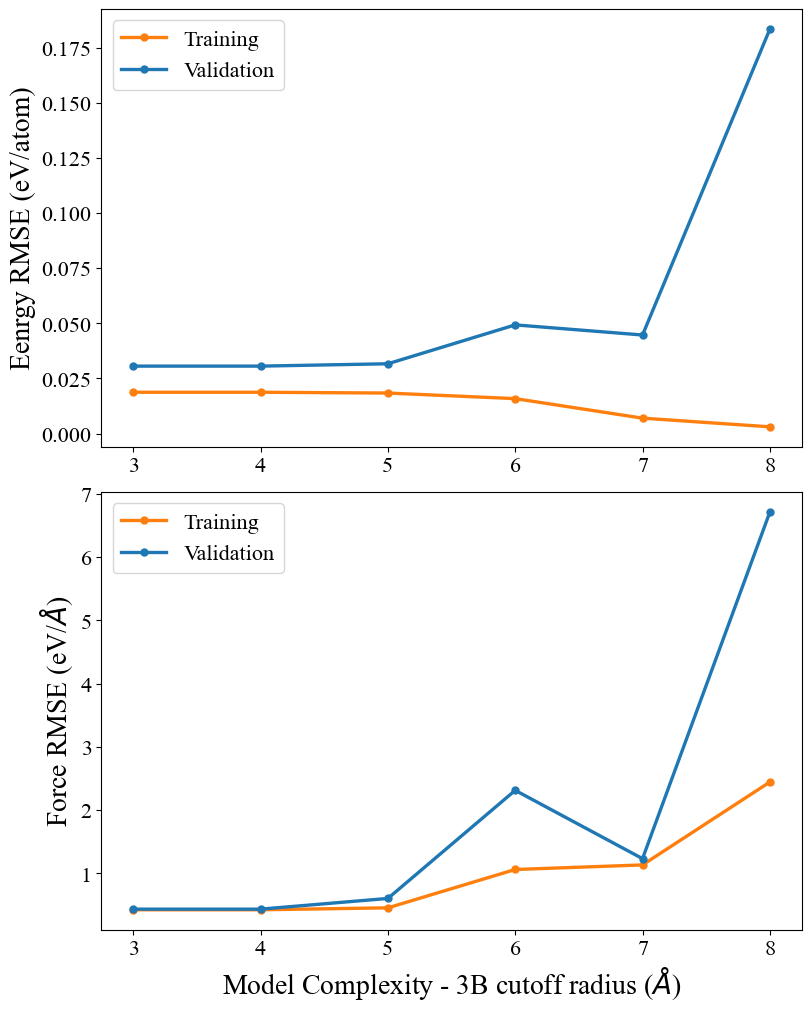

In [89]:
df_result.sort_values(by="rmax_3b",inplace=True)
plt.clf()
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.subplots_adjust(left=0.15,bottom=0.07,right=0.99,top=0.99,hspace=0.05)
fig, axs = plt.subplots(2,1,figsize=(8,10),constrained_layout = True)

energy_train_error = []
energy_valid_error = []

force_train_error = []
force_valid_error = []

cutoff_3b = df_result["rmax_3b"].unique()
for i in cutoff_3b:
    df_temp = df_result.loc[df_result["rmax_3b"]==i].copy()
    df_temp.sort_values(by="training_error_energy",inplace=True)
    energy_train_error.append(df_temp["training_error_energy"].to_numpy()[0])
    energy_valid_error.append(df_temp["validation_error_energy"].to_numpy()[0])
    
    force_train_error.append(df_temp["traininig_error_force"].to_numpy()[0])
    force_valid_error.append(df_temp["validation_error_force"].to_numpy()[0])

axs[0].plot(cutoff_3b,energy_train_error,'.-',color="tab:orange",lw=2.4,ms=10,label="Training")
axs[0].plot(cutoff_3b,energy_valid_error,'.-',color="tab:blue",lw=2.4,ms=10,label="Validation")
axs[0].set_ylabel("Eenrgy RMSE (eV/atom)",fontsize=20)
axs[0].legend()

axs[1].plot(cutoff_3b,force_train_error,'.-',color="tab:orange",lw=2.4,ms=10,label="Training")
axs[1].plot(cutoff_3b,force_valid_error,'.-',color="tab:blue",lw=2.4,ms=10,label="Validation")
axs[1].set_ylabel(r"Force RMSE (eV/$\AA$)",fontsize=20)
axs[1].legend()
axs[1].set_xlabel(r"Model Complexity - 3B cutoff radius ($\AA$)",fontsize=20)